# Sources

Places (Health) - https://chronicdata.cdc.gov/500-Cities-Places/PLACES-Census-Tract-Data-GIS-Friendly-Format-2022-/yjkw-uj5s\

In [1]:
### Import Libraries

# File manipulation

import os # For working with Operating System
from sys import platform # Diagnose operating system
import urllib # For accessing websites
import zipfile # For extracting from Zipfiles
from io import BytesIO # For reading bytes objects
import requests

# Analysis

import numpy as np # For working with Arrays
import pandas as pd # Data Manipulation
import geopandas as gpd # Spatial Data Manipulation

# Visualization

from pprint import pprint # Pretty Printing
import matplotlib.pyplot as plt # Basic Plotting
import contextily # Base Map Visualization
import warnings

warnings.filterwarnings('ignore') # Ignores some warnings

In [2]:
### Definitions

datapath = os.path.join('..', '..', 'Data')

mpls_tracts = gpd.read_file(os.path.join(datapath, 'mpls_tracts.geojson'))

In [3]:
# Keep track of fips codes for later queries

fips_codes = mpls_tracts.GEOID

## PLACES

In [4]:
# URL set up

# Full Data: 'https://chronicdata.cdc.gov/api/views/cwsq-ngmh/rows.csv?accessType=DOWNLOAD'

# API

base_url = 'https://chronicdata.cdc.gov/resource/cwsq-ngmh.csv?'

# We will query by measure and fips codes "Location id"

## Measure IDs

In [5]:
# Their API is weird...
# See here: https://dev.socrata.com/foundry/chronicdata.cdc.gov/cwsq-ngmh
# a "where" query was used with the "in" SoQL function


# Full list: 'Arthritis among adults aged >=18 years',
       # 'Stroke among adults aged >=18 years',
       # 'Current asthma among adults aged >=18 years',
       # 'Fair or poor self-rated health status among adults aged >=18 years',
       # 'Cervical cancer screening among adult women aged 21-65 years',
       # 'High cholesterol among adults aged >=18 years who have been screened in the past 5 years',
       # 'All teeth lost among adults aged >=65 years',
       # 'Visits to dentist or dental clinic among adults aged >=18 years',
       # 'Taking medicine for high blood pressure control among adults aged >=18 years with high blood pressure',
       # 'Mammography use among women aged 50-74 years',
       # 'Current lack of health insurance among adults aged 18-64 years',
       # 'Physical health not good for >=14 days among adults aged >=18 years',
       # 'Sleeping less than 7 hours among adults aged >=18 years',
       # 'High blood pressure among adults aged >=18 years',
       # 'Cancer (excluding skin cancer) among adults aged >=18 years',
       # 'Obesity among adults aged >=18 years',
       # 'Chronic kidney disease among adults aged >=18 years',
       # 'Older adult men aged >=65 years who are up to date on a core set of clinical preventive services: Flu shot past year, PPV shot ever, Colorectal cancer screening',
       # 'Coronary heart disease among adults aged >=18 years',
       # 'Depression among adults aged >=18 years',
       # 'No leisure-time physical activity among adults aged >=18 years',
       # 'Current smoking among adults aged >=18 years',
       # 'Visits to doctor for routine checkup within the past year among adults aged >=18 years',
       # 'Fecal occult blood test, sigmoidoscopy, or colonoscopy among adults aged 50-75 years',
       # 'Cholesterol screening among adults aged >=18 years',
       # 'Older adult women aged >=65 years who are up to date on a core set of clinical preventive services: Flu shot past year, PPV shot ever, Colorectal cancer screening, and Mammogram past 2 years',
       # 'Diagnosed diabetes among adults aged >=18 years',
       # 'Mental health not good for >=14 days among adults aged >=18 years',
       # 'Chronic obstructive pulmonary disease among adults aged >=18 years',
       # 'Binge drinking among adults aged >=18 years'

# Measure IDs
# 'ARTHRITIS', 'STROKE', 'CASTHMA', 'GHLTH', 'CERVICAL', 'HIGHCHOL',
#        'TEETHLOST', 'DENTAL', 'BPMED', 'MAMMOUSE', 'ACCESS2', 'PHLTH',
#        'SLEEP', 'BPHIGH', 'CANCER', 'OBESITY', 'KIDNEY', 'COREM', 'CHD',
#        'DEPRESSION', 'LPA', 'CSMOKING', 'CHECKUP', 'COLON_SCREEN',
#        'CHOLSCREEN', 'COREW', 'DIABETES', 'MHLTH', 'COPD', 'BINGE'

focus_measures = ['Stroke among adults aged >=18 years', 'Current asthma among adults aged >=18 years',
                  'Current lack of health insurance among adults aged 18-64 years', 
                  'High blood pressure among adults aged >=18 years',
                  'Chronic kidney disease among adults aged >=18 years', 
                  'Coronary heart disease among adults aged >=18 years', 
                  'Chronic obstructive pulmonary disease among adults aged >=18 years'
                 ]

focus_measureids = ['STROKE', 'BPMED', 'CASTHMA', 'ACCESS2', 'BPHIGH', 'KIDNEY', 'CHD', 'COPD']

focus_measureid_strings = []

for focus_measureid in focus_measureids:

    focus_measureid_string = '%20'.join(focus_measureid.split(' '))

    focus_measureid_strings += [focus_measureid_string]

measureid_str = "',%20'".join(focus_measureid_strings)

# Need to encode some characters?

urlencode_dict = {'<':'%3C',
                  '=':'%3D',
                  '>':'%3E',
                  "'":'%27'
                 }

for character in urlencode_dict:

    measureid_str = measureid_str.replace(character, urlencode_dict[character])

measureid_str = "$where=measureid%20in('" + measureid_str + "')"

In [6]:
# Their API appears to have a 1000 entry limit
# So we will query in a loop
# Iterating through the fips codes (locationid)

for i, fips_code in enumerate(fips_codes):

    locationid_str = 'locationid=' + str(fips_code)

    url = base_url + '&' + locationid_str + '&' + measureid_str

    data_i = pd.read_csv(url)

    # Concatenate with other data
    
    if i == 0:

        # Initialize storage
    
        cols = list(data_i.columns)
        
        datatypes = data_i.dtypes
        
        dtypes = np.dtype(list(zip(cols, datatypes)))
        
        full_df = pd.DataFrame(np.empty(0, dtype = dtypes))

    full_df = pd.concat([full_df, 
                        data_i],
                       ignore_index=True)

In [7]:
full_df.year.unique()

array([2020, 2019])

In [8]:
# Select the highest year

places_df = full_df[full_df.year == full_df.year.max()]

In [9]:
places_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 696 entries, 0 to 927
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   year                        696 non-null    int64  
 1   stateabbr                   696 non-null    object 
 2   statedesc                   696 non-null    object 
 3   countyname                  696 non-null    object 
 4   countyfips                  696 non-null    int64  
 5   locationname                696 non-null    int64  
 6   datasource                  696 non-null    object 
 7   category                    696 non-null    object 
 8   measure                     696 non-null    object 
 9   data_value_unit             696 non-null    object 
 10  data_value_type             696 non-null    object 
 11  data_value                  696 non-null    float64
 12  data_value_footnote_symbol  0 non-null      float64
 13  data_value_footnote         0 non-null  

In [10]:
# Lost high blood pressure & blood pressure med in the process..?

places_df.measureid.unique()

array(['STROKE', 'CASTHMA', 'KIDNEY', 'ACCESS2', 'COPD', 'CHD'],
      dtype=object)

## Merge Tracts with Data

STROKE


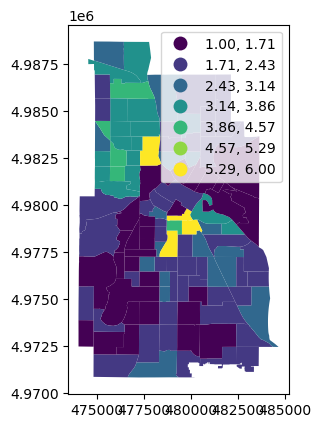

CASTHMA


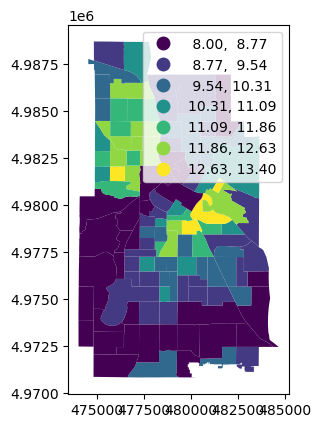

KIDNEY


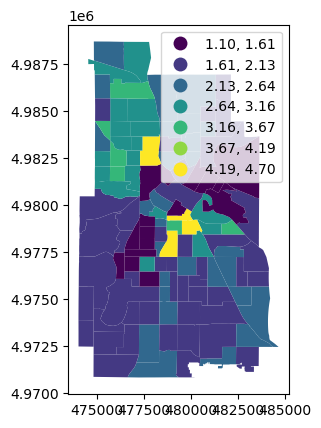

ACCESS2


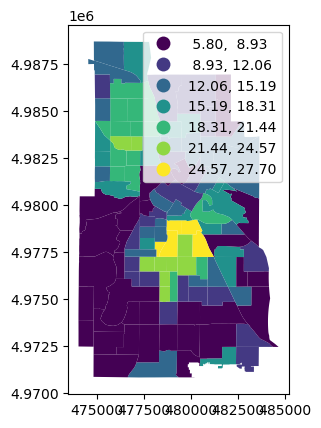

COPD


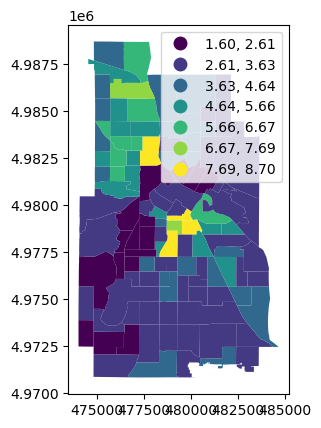

CHD


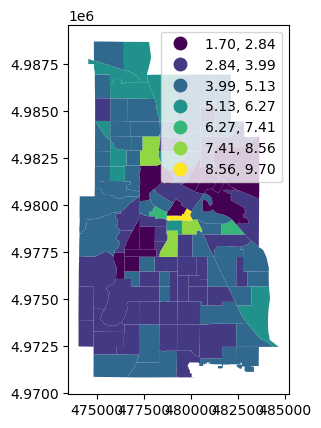

In [11]:
# Add data to tracts

tracts_with_data = mpls_tracts.copy()

# By measureid

for measureid in places_df.measureid.unique():

    print(measureid)
    
    measureid_df = places_df[places_df.measureid == measureid]

    stat_map = dict(zip(measureid_df.locationid, measureid_df['data_value']))
    
    tracts_with_data[measureid] = tracts_with_data.GEOID.astype(int).apply(lambda x: stat_map[x])
    tracts_with_data.plot(column = measureid, 
                          scheme = 'EqualInterval',
                          k=7,
                          legend = True)
    plt.show()

In [12]:
tracts_with_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 116 entries, 0 to 115
Data columns (total 19 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   STATEFP   116 non-null    object  
 1   COUNTYFP  116 non-null    object  
 2   TRACTCE   116 non-null    object  
 3   GEOID     116 non-null    object  
 4   NAME      116 non-null    object  
 5   NAMELSAD  116 non-null    object  
 6   MTFCC     116 non-null    object  
 7   FUNCSTAT  116 non-null    object  
 8   ALAND     116 non-null    int64   
 9   AWATER    116 non-null    int64   
 10  INTPTLAT  116 non-null    object  
 11  INTPTLON  116 non-null    object  
 12  geometry  116 non-null    geometry
 13  STROKE    116 non-null    float64 
 14  CASTHMA   116 non-null    float64 
 15  KIDNEY    116 non-null    float64 
 16  ACCESS2   116 non-null    float64 
 17  COPD      116 non-null    float64 
 18  CHD       116 non-null    float64 
dtypes: float64(6), geometry(1), int64(2), obje

In [13]:
# Looks good, let's save

cols = ['GEOID'] + list(places_df.measureid.unique()) + ['geometry']

tracts_with_data[cols].to_file(os.path.join(datapath, 'mpls_health.geojson'))